**Import the packages**

In [1]:
import gymnasium as gym
from stable_baselines3 import DDPG, PPO
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
import numpy as np
import base64
from PIL import Image
import io
import os
from openai import OpenAI
from openaikey import OPENAI_API_KEY
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from stable_baselines3.common.logger import configure
import custom_parking
import imageio
from utils import record_videos, show_videos

/Users/noahwiley-class/.pyenv/versions/3.10.1/envs/6.8200/lib/python3.10/site-packages/gym/wrappers/monitoring/video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn


**Defining Functions for Vision**

In [8]:
def env_render_to_base64(env):
    env.reset()
    rendered = env.render()
    # Convert numpy array to PIL Image
    image = Image.fromarray(rendered)

    # Save the image to a BytesIO object
    buffer = io.BytesIO()
    image.save(buffer, format='JPEG')

    # Get the content of the BytesIO object
    image_bytes = buffer.getvalue()

    # Encode the bytes to base64
    image_base64 = base64.b64encode(image_bytes)

    # If you need it as a string
    image_base64_str = image_base64.decode('utf-8')
    return image_base64_str

def prompt_api_vision(openai_client, prompt, image64) -> str:
    response = openai_client.chat.completions.create(
    model="gpt-4-turbo",
    messages = [
        {
        "role": "user",
        "content": [
            {
            "type": "text",
            "text": prompt,
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{image64}",
                "detail": "low"
            },
            },
        ],
        }
    ],
    max_tokens=600,
    )
    return response.choices[0].message.content

def prompt_api_no_vision(openai_client, prompt1) -> str:
    response = openai_client.chat.completions.create(
    model="gpt-4-turbo",
    messages = [
        {
        "role": "user",
        "content": [
            {
            "type": "text",
            "text": prompt1,
            },
        ],
        }
    ],
    max_tokens=600,
    )
    return response.choices[0].message.content

**Define Prompts for API and generate reward function**

In [9]:
# Create an OpenAI client
client = OpenAI(api_key=OPENAI_API_KEY)

#getting render of the environment
def compute_reward(self, achieved_goal: np.ndarray, desired_goal: np.ndarray, info: dict = None, p: float = 0.5) -> float:
       return 0.0

env = gym.make("CustomParking-v0",  compute_reward=compute_reward, render_mode="rgb_array")
env.reset()

image_base64_str = env_render_to_base64(env)

# PROMPTS FOR THE CLIENT
env_description = """
Here is an image of a top-down view of a parking lot. 
The parking area is surrounded by a yellow border.
The parking lot has numerous empty parking spots marked by white lines on a gray surface. 
There is a green car which can be controlled via throttle and steering angle. 
There is a blue object which represents the goal parking spot where we would like the car to end up within the neighboring white lines. 
Our observations come in the form of a tuple of:
OrderedDict([
             ('observation', array([ 0., 0. ,0., -0.,  0.65025885, -0.75971273])), 
             ('achieved_goal', array([ 0.,  0.,  0., -0.,  0.65025885, -0.75971273])),
             ('desired_goal', array([2.200000e-01, 1.400000e-01, 0.000000e+00, 0.000000e+00, 6.123234e-17, 1.000000e+00]))
            ]),
Where each array corresponds to the following: ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'] of the car.
Please describe 5 behavoirs in natural language that would incentivize an agent to efficiently learn how to park the car on the blue spot at the right angle.
"""

language_to_code_prompt = """
You are an assistant tasked with turning language subgoals into machine readable code. You will be given a list of text subgoals/desired behaviors, and you must translate these subgoals into code that takes in an observation of the format:
OrderedDict([
             ('observation', array([ 0., 0. ,0., -0.,  0.65025885, -0.75971273])), 
             ('achieved_goal', array([ 0.,  0.,  0., -0.,  0.65025885, -0.75971273])),
             ('desired_goal', array([2.200000e-01, 1.400000e-01, 0.000000e+00, 0.000000e+00, 6.123234e-17, 1.000000e+00]))
            ])
Where each array corresponds to the following: ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'] of the car's current state and desired state.
Feel free to use if statements, loops, or any other python code to achieve all 5 behaviors.
Please respond with only the code for the reward function which is defined by def compute_reward(achieved_goal: np.ndarray, desired_goal: np.ndarray, info: dict, p: float = 0.5) -> float:
The reward function should address each point in the following list:
""" 

natural_language = language_to_code_prompt + prompt_api_vision(client, env_description, image_base64_str)
print(natural_language)
code = prompt_api_no_vision(client, language_to_code_prompt)
print(code)


You are an assistant tasked with turning language subgoals into machine readable code. You will be given a list of text subgoals/desired behaviors, and you must translate these subgoals into code that takes in an observation of the format:
OrderedDict([
             ('observation', array([ 0., 0. ,0., -0.,  0.65025885, -0.75971273])), 
             ('achieved_goal', array([ 0.,  0.,  0., -0.,  0.65025885, -0.75971273])),
             ('desired_goal', array([2.200000e-01, 1.400000e-01, 0.000000e+00, 0.000000e+00, 6.123234e-17, 1.000000e+00]))
            ])
Where each array corresponds to the following: ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'] of the car's current state and desired state.
Feel free to use if statements, loops, or any other python code to achieve all 5 behaviors.
Please respond with only the code for the reward function which is defined by def compute_reward(achieved_goal: np.ndarray, desired_goal: np.ndarray, info: dict, p: float = 0.5) -> float:
The reward function sh

In [4]:
# TODO REPLACE THE REWARD FUNCTION WITH THE GENERATED CODE
def compute_reward(self, achieved_goal: np.ndarray, desired_goal: np.ndarray, info: dict, p: float = 0.5) -> float:
    # Extract positions and heading information from goals
    x_a, y_a, _, _, cos_h_a, sin_h_a = achieved_goal
    x_d, y_d, _, _, cos_h_d, sin_h_d = desired_goal
    
    # Calculate the position difference
    position_error = np.sqrt((x_d - x_a)**2 + (y_d - y_a)**2)
    
    # Calculate the angle difference
    heading_error = np.arccos(np.clip(cos_h_a * cos_h_d + sin_h_a * sin_h_d, -1.0, 1.0))
    
    # Define thresholds
    position_threshold = 0.1
    heading_threshold = 0.1 * np.pi  # 18 degrees
    
    # Compute partial rewards based on position and heading calculations
    position_reward = np.exp(-p * position_error)
    heading_reward = np.exp(-p * (heading_error**2))  # Squared to make heading error more significant
    
    # Aggregate the rewards, giving half weight to position and half to heading
    reward = 0.5 * position_reward + 0.5 * heading_reward
    
    # Reward shaping for better learning behavior (optional depending on scenario requirements)
    if position_error < position_threshold and heading_error < heading_threshold:
        # Adding extra reward for being sufficiently close to the desired goal
        reward += 1.0
    
    return reward

**CREATING ENV, AGENT, and TRAINING**

In [12]:
mode = "USE_DDPG"
training_steps = 1000

env = gym.make("CustomParking-v0",  compute_reward=compute_reward, render_mode="rgb_array")

# FOR DDPG
if mode == "USE_DDPG":
    # set up logger
    tmp_path = "wiley/log" # PATH FOR LOGGING
    new_logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    #set noise for ddpg
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
    # creating model and assign logger
    model = DDPG("MultiInputPolicy", env, verbose=0)
    model.set_logger(new_logger)
    model.learn(total_timesteps=training_steps)
    model.save("wiley/models/ddpg_parking_ai_reward")

# FOR PPO
if mode == "USE_PPO":
    # set up logger
    tmp_path = "wiley/log" # PATH FOR LOGGING
    new_logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # creating model and assign logger
    model = PPO("MultiInputPolicy", env, verbose=0)
    model.set_logger(new_logger)
    model.learn(total_timesteps=training_steps)
    model.save("wiley/models/ppo_parking_ai_reward")



Logging to wiley/log
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.696    |
|    success_rate    | 1        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 126      |
|    time_elapsed    | 0        |
|    total_timesteps | 4        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.639    |
|    success_rate    | 1        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 131      |
|    time_elapsed    | 0        |
|    total_timesteps | 8        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.643    |
|    success_rate    | 1        |
| time/              |          |
|    episodes        | 12  

**Loading Models and running simulation**

In [ ]:
images = []
obs = model.env.reset()
img = model.env.render(mode="rgb_array")
for i in range(350):
    images.append(img)
    action, _ = model.predict(obs)
    obs, _, _ ,_ = model.env.step(action)
    img = model.env.render(mode="rgb_array")

imageio.mimsave("lander_a2c.gif", [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)

In [7]:
mode = "USE_DDPG"
env = gym.make("CustomParking-v0",  compute_reward=compute_reward, render_mode="rgb_array")
if mode == "USE_DDPG":
    model = DDPG.load("wiley/models/ddpg_parking_ai_reward", env=env)
if mode == "USE_PPO":
    model = PPO.load("wiley/models/ppo_parking_ai_reward", env=env)

images = []
obs = model.env.reset()
img = model.env.render(mode="rgb_array")
for i in range(350):
    images.append(img)
    action, _ = model.predict(obs)
    obs, _, _ ,_ = model.env.step(action)
    img = model.env.render(mode="rgb_array")

imageio.mimsave(f"car{mode}.gif", [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/noahwiley-class/.pyenv/versions/3.10.1/envs/6.8200/lib/python3.10/site-packages/imageio/plugins/pillow.py:409: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


**Plot Training Logs**

Index(['time/total_timesteps', 'rollout/success_rate', 'rollout/ep_rew_mean',
       'time/episodes', 'rollout/ep_len_mean', 'time/fps', 'time/time_elapsed',
       'train/actor_loss', 'train/learning_rate', 'train/critic_loss',
       'train/n_updates'],
      dtype='object')


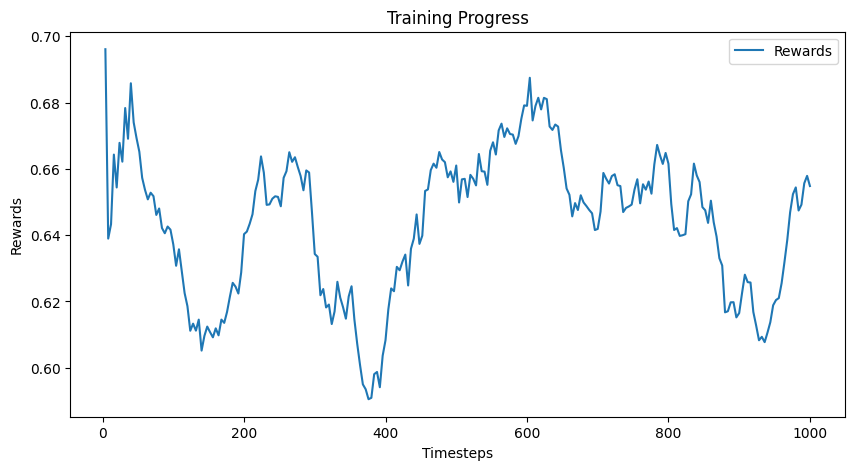

In [13]:
log_path = 'wiley/log/progress.csv'  # Adjust the path as needed
df = pd.read_csv(log_path)
print(df.columns)

plt.figure(figsize=(10, 5))
plt.plot(df['time/total_timesteps'], df['rollout/ep_rew_mean'], label='Rewards')
plt.xlabel('Timesteps')
plt.ylabel('Rewards')
plt.title('Training Progress')
plt.legend()
plt.show()